In [1]:
!pip install eli5

In [2]:
!pip install youtokentome

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn import metrics
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import FunctionTransformer
import eli5
from matplotlib import pyplot
from eli5.sklearn import PermutationImportance
from nltk.corpus import stopwords
from string import punctuation
from sklearn.ensemble import VotingClassifier 
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from string import punctuation
from collections import Counter
import youtokentome as yttm
import matplotlib.pyplot as plt
import re
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [5]:
from google.colab import drive 
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [6]:
data = pd.read_csv('/gdrive/My Drive/exam/jigsaw-toxic-comment-train.csv.zip')

## 1. Описательный анализ данных с привязкой к целевой переменной (toxic) и 2 другим дополнительным колонкам (как минимум 5 статистик на каждую группу) - 1.5 балл

In [ ]:
data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
len(data[data['toxic']==1])

21384

In [ ]:
len(data[data['toxic']==0])

202165

In [ ]:
data.shape

(223549, 8)

In [ ]:
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

In [ ]:
stops = stopwords.words('english')

In [ ]:
data['text_len'] = data['comment_text'].apply(len) #длина текста
data['text_len_tokens'] = data['comment_text'].apply(lambda x: len(x.split())) #количество токенов
data['number_of_caps'] = data['comment_text'].apply(lambda x: len([ch for ch in x if ch.isupper()])) #количество слов с заглавной буквы
data['number_of_nonalphanum'] = data['comment_text'].apply(lambda x: len([ch for ch in x if not ch.isalnum()])) #количество  не буквенно-цифровых символов
data['number_of_lows'] = data['comment_text'].apply(lambda x: len([ch for ch in x if ch.islower()])) #количество строчных букв
data['number_of_digits'] = data['comment_text'].apply(lambda x: len([ch for ch in x if ch.isdigit()])) #количество цифр
data['number_of_ascii'] = data['comment_text'].apply(lambda x: len([ch for ch in x if is_ascii(ch)])) #количество ascii символов
data['number_of_nonascii'] = data['comment_text'].apply(lambda x: len([ch for ch in x if not is_ascii(ch)])) #количество non-ascii символов
data['number_of_punctuation'] = data['comment_text'].apply(lambda x: len([ch for ch in x if ch in punctuation])) #количество знаков пунктуации
data['number_of_stops'] = data['comment_text'].apply(lambda x: len([ch for ch in x if ch in stops])) #количество стоп-слов

In [ ]:
data.head(3)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,43,17,52,186,9,264,0,10,84
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,17,8,29,65,10,112,0,12,29
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,42,4,47,182,0,233,0,6,99


### Отдельные колонки

### Toxic/Non-toxic

In [ ]:
data.groupby('toxic')['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
toxic,,,,,,,,,,
0,402.691178,68.415161,14.484189,89.072456,294.922009,3.248698,400.972142,1.719036,16.974704,141.799609
1,280.604097,48.573466,44.689675,65.266741,168.618921,1.995885,280.409512,0.194585,14.257202,80.432941


1. Средняя длина нетоксичного комментария выше, чем у токсичного. 
2. Среднее количество слов у нетоксичных текстов также больше. 
3. Среднее количество используемых заглавных букв у токсичных сообщений в несколько рах выше, чем у нетоксичных.
4. Среднее количество  не буквенно-цифровых символов в нетоксичных комментариях выше.
5. Количество строчных букв в токсичных комментариях меньше, чем в нетоксичных.
6. Цифр в нетоксичных комментариях также в среднем больше. 
7. Ascii-символов в нетоксичных комментариях больше.
8. Не-ascii символов в целом по комментариям практически нет, но если они встречаются, то чаще в нетоксичных комментариях.
9. Оба типа комментариев имеют практически одинаковое среднее количество знаков препинания. В нетоксичных комментариях их чуть больше. 
10. Используемых стоп-слов в нетоксичных комментариях гораздо больше, чем в токсичных.

### Severe_toxic/Non-severe_toxic

In [ ]:
data.groupby('severe_toxic')['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
severe_toxic,,,,,,,,,,
0,389.999386,66.358270,15.988131,86.500630,283.491852,3.136258,388.413228,1.586158,16.591014,136.307514
1,505.456677,84.462793,173.841998,120.072375,209.248726,2.293068,505.345566,0.111111,30.690112,93.232926


1. Средняя длина сильно токсичных комментариев гораздо больше. 
2. Среднее количество слов в сильно токсичных комментариях выше.
3. Количество заглавных букв в сильно токсичных текстах во много раз превышает количество в обычных комментариях.
4. Среднее количество не буквенно-цифровых символов в токсичных комментариях выше.
5. Строчных букв в обычных комментариях больше. 
6. В обоих типах комментариев цифр мало, но в обычных комментариях в среднем чуть больше.
7. Ascii-символов больше в сильно токсичных комментариях.
8. Не-ascii символы практически отсутствуют в обоих типах. В обычных чуть больше.
9. Количество знаков пунктуации в среднем почти в 2 раза больше в токсичных комментариях.
10. Количество стоп-слов в обычных комментариях в среднем больше. 

### Obscene/Non-obscene

In [ ]:
data.groupby('obscene')['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
obscene,,,,,,,,,,
0,397.332876,67.559707,15.299590,88.032052,289.883993,3.193029,395.678353,1.654523,16.850087,139.417163
1,280.951730,48.362109,53.490033,65.257743,160.178748,2.011367,280.794481,0.157249,14.358072,75.193822


1. Средняя длина грубых комментарией намного меньше, чем обычных.
2. Количество слов в грубых текстах также меньше в среднем на 19.
3. Заглавных букв в грубых комментариях во много раз больше.
4. Среднее количество не буквенно-цифровых символов в грубых комментариях меньше.
5. Негрубые тексты содержат гораздо больше строчных букв. 
6. Оба типа комментариев содержат мало цифр. В негрубых их в среднем на 1 больше.
7. Количество ascii-символов практически полностью совпадает со средней длиной комментариев в обих типах.
8. В негрубых в среднем встречается 1.6 не ascii-символов, что чуть больше, чем в грубых.
9. Количество знаков пунктуации практически одинаковое, но в негрубых их на 2 больше, чем в грубых.
10. В грубых комментариях используется меньше стоп-слов, чем в негрубых почти в 2 раза.

### Threat/Non-threat

In [ ]:
data.groupby('threat')['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
threat,,,,,,,,,,
0,391.241807,66.547128,17.149430,86.796312,283.283766,3.134856,389.665157,1.576649,16.686637,136.141282
1,316.910015,56.825835,89.866473,86.460087,139.383164,1.188679,316.448476,0.461538,25.809869,67.416546


1. Длина текстов с угрозой меньше, чем текстов без угрозы.
2. Количество слов в текстах без угрозы на 10 больше. 
3. Количество заглавных букв в текстах с угрозой во много раз больше, чем в текстах без.
4. Среднее количество не буквенно-цифровых символов одинаково.
5. Количество строчных букв в текстах без угрозы больше, чем в 2 раза.
6. Количество цифр в обоих типах мало, но в текстах без угрозы их в среднем чуть больше.
7. Количество ascii-символов практически полностью совпадает со средней длиной комментариев в обих типах.
8. Не ascii-символы практически отсутствуют в обоих типах. В текстах без угрозы в среднем их 1.6.
9. Знаки пунктуации присутствуют в обоих типах комментариев и их количество почти одинаковое.
10. Количество использованных стоп-слов больше в текстах без угрозы в 2 раза. 

### Insult/Non-insult

In [ ]:
data.groupby('insult')['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
insult,,,,,,,,,,
0,397.340234,67.544536,15.573931,88.053302,289.597522,3.194615,395.690669,1.649565,16.879710,139.233245
1,272.206476,47.227176,51.163393,63.174452,155.965057,1.894197,272.066879,0.139597,13.617569,73.897381


1. Средняя длина комментария с оскорблением меньше, чем обычный комментарий.
2. В обычном комментарии в среднем на 20 слов больше, чем в тексте с оскорблением.
3. Количество заглавных букв в тексте с оскорблением в несколько раз больше.
4. Среднее количество не буквенно-цифровых символов в обычных комментариях больше, чем в оскорбительных.
5. Количество строчных букв почти в 2 раза больше в комментариях без оскорбления.
6. Количество цифр в обоих типах мало, но в текстах без оскорбления их в среднем чуть больше.
7. Количество ascii-символов практически полностью совпадает со средней длиной комментариев в обих типах.
8. Не ascii-символы практически отсутствуют в обоих типах. В текстах без оскорбления в среднем их 1.6.
9. Знаки пунктуации присутствуют в обоих типах комментариев и их количество почти одинаковое.
10. Количество использованных стоп-слов больше в текстах без оскорбления в 2 раза.

### Identity_hate/Non-identity_hate

In [ ]:
data.groupby('identity_hate')['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,text_len,text_len_tokens,number_of_caps,number_of_nonalphanum,number_of_lows,number_of_digits,number_of_ascii,number_of_nonascii,number_of_punctuation,number_of_stops
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
identity_hate,,,,,,,,,,
0,391.744793,66.651428,16.774599,86.960259,283.989184,3.137812,390.158234,1.586559,16.740187,136.492779
1,314.438829,52.473784,80.022201,69.538498,162.665092,2.192253,314.261691,0.177137,14.054795,77.008503


1. Средняя длина комментария без ненависти личности больше на примерно 75 слов.
2. Обычные комментарии в среднем имеют больше слов.
3. Количество заглавных букв в тексте с ненавистью личности в несколько раз больше.
4. Среднее количество не буквенно-цифровых символов в обычных комментариях больше. 
5. Количество строчных букв почти в 2 раза больше в комментариях без ненависти.
6. Количество цифр в обоих типах мало, но в текстах без оскорбления их в среднем чуть больше.
7. Количество ascii-символов практически полностью совпадает со средней длиной комментариев в обих типах.
8. Не ascii-символы практически отсутствуют в обоих типах. В текстах без ненависти в среднем их 1.58.
9. Знаки пунктуации присутствуют в обоих типах комментариев и их количество почти одинаковое.
10. Количество использованных стоп-слов больше в текстах без ненависти меньше, чем в 2 раза.

### Привязка к другим колонкам

### Toxic/Insult

In [ ]:
data.groupby(['toxic', 'insult'])['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


text_len text_len_tokens  ... number_of_punctuation number_of_stops
                    mean            mean  ...                  mean            mean
toxic insult                              ...                                      
0     0       402.813001       68.433497  ...             16.978293      141.864081
      1       362.961165       62.435275  ...             15.804207      120.773463
1     0       294.234997       50.796784  ...             15.022434       89.669097
      1       266.957889       46.347651  ...             13.491110       71.186412

[4 rows x 10 columns]

1. Non-toxic/non-insult имеют самую большую среднюю длину. В non-toxic/insult комментариях длина текста больше, чем просто в toxic/non-insult. Toxic/insult в свою очередь имеют самые короткие тексты.
2. Non-toxic/non-insult имеют самое большое количество слов. В insult комментариях слов в среднем на 12 больше, чем просто в toxic/non-insult. Toxic/insult в свою очередь имеют меньше всего слов.
3. Заглавных букв больше всего в комментариях имеющие обе метки toxic/insult. Меньше всего в обычных комментариях без меток. Токсичные комментарии имеют больше заглавных букв, чем оскорбительные.
4. Среднее количество не буквенно-цифровых символов в обычных комментариях больше. Toxic/non-insult комментарии имеют меньше данных символов, чем non-toxic/insult. 
5. Количество строчных букв больше всего в комментариях без меток. Меньше всего строчных букв в комментариях с обеими метками toxic и insult. 
6. В комментариях всех типов используется мало цифр. Больше всего в текстах non-toxic/insult, меньше всего в toxic/insult. 
7. Количество ascii-символов практически полностью совпадает со средней длиной комментариев во всех типах.
8. Не ascii-символы практически отсутствуют в данных типах.
9. Знаков пунктуации больше всего в обычных комментариях. В комментариях toxic/insult их наименьшее количество.
10. Больше всего стоп-слов в обычных комментариях. Меньше всего в toxic/insult. В toxic/non-insult их меньше, чем в non-toxic/insult.

### Toxic/Obscene

In [ ]:
data.groupby(['toxic', 'obscene'])['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


text_len text_len_tokens  ... number_of_punctuation number_of_stops
                     mean            mean  ...                  mean            mean
toxic obscene                              ...                                      
0     0        402.480948       68.373545  ...             16.961355      141.744579
      1        474.761905       82.681973  ...             21.551020      160.664966
1     0        291.786412       50.874288  ...             14.568857       91.700163
      1        271.086738       46.615218  ...             13.991949       70.843317

[4 rows x 10 columns]

1. Non-toxic/obscene комментарии являются самыми длинными. Toxic/obscene имеют самую маленькую длину.
2. Больше всего слов в грубых комментариях non-toxic/obscene. Меньше всего в toxic/obscene вместе.
3. Наибольшее количество заглавных букв наблюдается в toxic/obscene комментариях. В нормальных комментариях их меньше всего. Грубые и токсичные комментарии отдельно имеют примерно одинаковое количество заглавных букв.
4. Среднее количество не буквенно-цифровых символов в грубых комментариях больше. Toxic/obscene комментарии имеют меньше всего данных символов.
5. Больше всего строчных букв в грубых комментариях non-toxic/obscene. Toxic/obscene имеют меньше всего данных букв.
6. В комментариях всех типов используется мало цифр. Больше всего в текстах obscene, меньше всего в toxic/obscene.
7. Количество ascii-символов практически полностью совпадает со средней длиной комментариев в обих типах.
8. Не ascii-символы практически отсутствуют в данных типах.
9. Больше всего знаков пунктуации в грубых комментариях non-toxic/obscene.
10. Non-toxic/obscene грубые комментарии имеют больше всего стоп-слов. Меньше всего в toxic/obscene.

### Toxic/Threat

In [ ]:
data.groupby(['toxic', 'threat'])['text_len', 'text_len_tokens', 'number_of_caps', 'number_of_nonalphanum', 'number_of_lows', 'number_of_digits', 
                      'number_of_ascii', 'number_of_nonascii', 'number_of_punctuation', 'number_of_stops'].agg(['mean'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


text_len text_len_tokens  ... number_of_punctuation number_of_stops
                    mean            mean  ...                  mean            mean
toxic threat                              ...                                      
0     0       402.693648       68.415233  ...             16.975268      141.805764
      1       388.428571       68.000000  ...             13.714286      106.257143
1     0       279.579450       48.331983  ...             13.872311       80.909165
      1       313.082569       56.227829  ...             26.457187       65.337920

[4 rows x 10 columns]

1. Обычные комментарии самые длинные. Самыми короткими являются комментарии типа toxic/non-threat. В non-toxic/threat также наблюдается большая средняя длина. 
2. Обычные комментарии и non-toxic/threat имеют одинаковое среднее количество слов. Меньше всего слов в toxic/non-threat комментариях. 
3. Заглавных букв больше всего в toxic/threat комментариях. Меньше всего в обычных. Тексты с угрозой имеют больше заглавных букв, чем токсичные.
4. Среднее количество не буквенно-цифровых символов незначительно отличается. В toxic/non-threat комментариях их меньше всего. В остальных типах их примерно одинаково.
5. Больше всего строчных букв в обычных комментариях. Меньше всего в toxic/threat. Non-toxic/threat имеют больше строчных букв, чем toxic/non threat. 
6. В комментариях всех типов используется мало цифр. Больше всего в текстах threat, меньше всего в toxic/threat.
7. Количество ascii-символов практически полностью совпадает со средней длиной комментариев в обих типах.
8. Не ascii-символы практически отсутствуют в данных типах.
9. Больше всего знаков пунктуации в текстах toxic/threat. В toxic/non-threat и non-toxic/threat их примерно одинаково.
10. Наибольшее количество стоп-слов наблюдается в текстах комментариев типа non-toxic/non-threat. Меньше всего в toxic/threat. В комментариях non-toxic/threat их больше, чем в toxic/non-threat. 

## 2. Бейзлайн модель из sklearn (векторайзер + модель) с отбором признаков (через l1 регуляризацию, на глаз через анализ важных параметров или через permutation importance) - 2 балл

### Бейзлайн на всех данных

In [7]:
X = data['comment_text']
y = data['toxic']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
count_vect = CountVectorizer()

In [10]:
X_train = count_vect.fit_transform(X_train)
X_train.shape

(149777, 207901)

In [11]:
X_test = count_vect.transform(X_test)
X_test.shape

(73772, 207901)

In [12]:
clf = SGDClassifier().fit(X_train, y_train)

In [13]:
y_pred = clf.predict(X_test)

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     66765
           1       0.85      0.55      0.67      7007

    accuracy                           0.95     73772
   macro avg       0.90      0.77      0.82     73772
weighted avg       0.94      0.95      0.94     73772



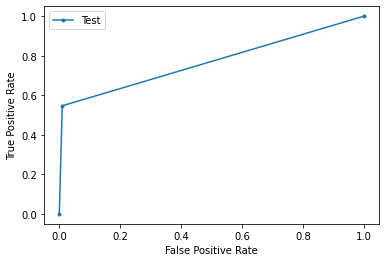

In [15]:
y_true = y_test
y_predicted = y_pred 
fpr, tpr, _ = roc_curve(y_true, y_predicted)
pyplot.plot(fpr, tpr, marker='.', label='Test')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

### Бейзлайн на даунсэмпле (для ансамблей и нейронных сетей)

In [16]:
from sklearn.utils import resample

data_majority = data[data.toxic==0]
data_minority = data[data.toxic==1]
length = len(data_minority)

data_majority_downsampled = resample(data_majority, 
                                 replace=False,    
                                 n_samples=length,     
                                 random_state=123) 

data_downsampled = pd.concat([data_majority_downsampled, data_minority])

In [17]:
X = data_downsampled['comment_text']
y = data_downsampled['toxic']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
count_vect = CountVectorizer()

In [11]:
X_train = count_vect.fit_transform(X_train)
X_train.shape

(28654, 64225)

In [12]:
X_test = count_vect.transform(X_test)
X_test.shape

(14114, 64225)

In [13]:
clf = SGDClassifier().fit(X_train, y_train)

In [14]:
y_pred = clf.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      7072
           1       0.89      0.89      0.89      7042

    accuracy                           0.89     14114
   macro avg       0.89      0.89      0.89     14114
weighted avg       0.89      0.89      0.89     14114



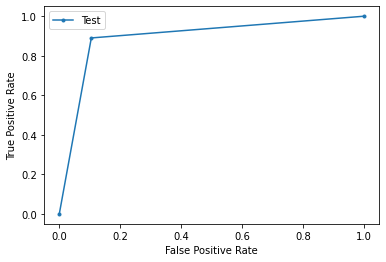

In [16]:
y_true = y_test
y_predicted = y_pred 
fpr, tpr, _ = roc_curve(y_true, y_predicted)
pyplot.plot(fpr, tpr, marker='.', label='Test')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

### Top features Eli5

На всех данных

In [ ]:
eli5.formatters.as_dataframe.explain_weights_df(clf)


,target,feature,weight
0,1,x70089,2.116671
1,1,x84835,2.067145
2,1,x64497,2.009007
3,1,x20704,1.970248
4,1,x69133,1.912109
...,...,...,...
71457,1,x23850,-1.195068
71458,1,x69507,-1.287659
71459,1,x166952,-1.511600
71460,1,x122363,-2.082218


In [ ]:
def analyze_features(model, n):
  index_to_word = {v:k for k,v in count_vect.vocabulary_.items()}
  data = eli5.formatters.as_dataframe.explain_weights_df(model)
  
  class1 = data[data['target']==1]
  
  print('\n', n, 'самых значимых признаков класса (toxic):')
  for element in class1.feature[:n]:
    feature = element.strip('x')
    print(index_to_word[int(feature)], element)

In [ ]:
analyze_features(clf, 30)


 30 самых значимых признаков класса (toxic):
fuck x70089
idiot x84835
faggot x64497
asshole x20704
france x69133
fucking x70128
idiots x84845
suck x164233
shit x154929
bitch x28022
fucked x70099
stupid x163563
cunt x46526
moron x114373
bark x24314
niggers x119867
ass x20589
sucks x164261
motherfucker x114630
bullshit x32375
bastard x24691
penis x129840
nigger x119855
jerk x91987
fuckin x70126
dumbass x56450
cock x40275
aidsaids x13669
fag x64461
nigga x119839


In [ ]:
sum(sum(clf.coef_ != 0))


71461

In [ ]:
top_features = [int(i[1:]) for i in eli5.formatters.as_dataframe.explain_weights_df(clf).feature if 'BIAS' not in i]

In [ ]:
len(top_features)

71461

### Top features without BIAS

In [ ]:
X_train_eli5 = X_train[:,top_features]
X_test_eli5 = X_test[:,top_features]

In [ ]:
eli5_model = SGDClassifier().fit(X_train_eli5, y_train)

In [ ]:
y_pred = eli5_model.predict(X_test_eli5)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     66765
           1       0.80      0.61      0.70      7007

    accuracy                           0.95     73772
   macro avg       0.88      0.80      0.83     73772
weighted avg       0.95      0.95      0.95     73772



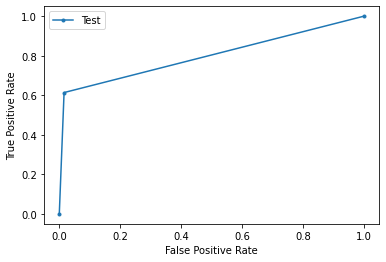

In [ ]:
y_true = y_test
y_predicted = y_pred 
fpr, tpr, _ = roc_curve(y_true, y_predicted)
pyplot.plot(fpr, tpr, marker='.', label='Test')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

По сравнению с бейзлайном на всех данных precision метки 1 снизился до 0.81. Все остальные метрики не изминились.

### Top 1000 features

In [ ]:
top1000_features = top_features[:1000]

In [ ]:
X_train_eli5 = X_train[:,top1000_features]
X_test_eli5 = X_test[:,top1000_features]

In [ ]:
eli5_model = SGDClassifier().fit(X_train_eli5, y_train)

In [ ]:
y_pred = eli5_model.predict(X_test_eli5)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     66765
           1       0.78      0.49      0.60      7007

    accuracy                           0.94     73772
   macro avg       0.86      0.74      0.79     73772
weighted avg       0.93      0.94      0.93     73772



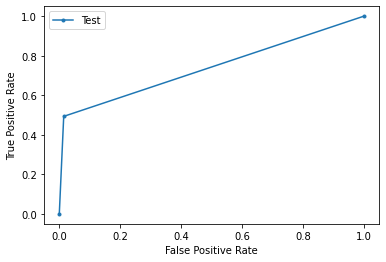

In [ ]:
y_true = y_test
y_predicted = y_pred 
fpr, tpr, _ = roc_curve(y_true, y_predicted)
pyplot.plot(fpr, tpr, marker='.', label='Test')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

По сравнению с бейзлайном на всех данных precision метки 1 снизился до 0.70, recall меток 0 и 1 снизился до 0.98 и 0.49, f1-score снизился до 0.93.

### Top 10000 features

In [ ]:
top10000_features = top_features[:10000]

In [ ]:
X_train_eli5 = X_train[:,top10000_features]
X_test_eli5 = X_test[:,top10000_features]

In [ ]:
eli5_model = SGDClassifier().fit(X_train_eli5, y_train)

In [ ]:
y_pred = eli5_model.predict(X_test_eli5)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     66765
           1       0.79      0.49      0.61      7007

    accuracy                           0.94     73772
   macro avg       0.87      0.74      0.79     73772
weighted avg       0.93      0.94      0.93     73772



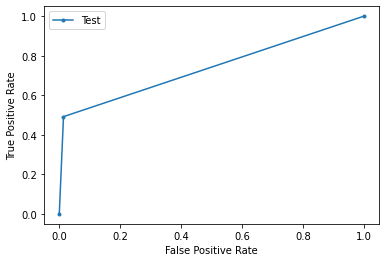

In [ ]:
y_true = y_test
y_predicted = y_pred 
fpr, tpr, _ = roc_curve(y_true, y_predicted)
pyplot.plot(fpr, tpr, marker='.', label='Test')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

По сравнению с бейзлайном на всех данных precision меток 0 и 1 снизился до 0.95 0.78, recall меток 0 и 1 снизился до 0.98 и 0.55, f1-score снизился до 0.94. Результаты по сравнению с top 1000 features улучшились. 

### Top 30000 features

In [ ]:
top30000_features = top_features[:30000]

In [ ]:
X_train_eli5 = X_train[:,top30000_features]
X_test_eli5 = X_test[:,top30000_features]

In [ ]:
eli5_model = SGDClassifier().fit(X_train_eli5, y_train)

In [ ]:
y_pred = eli5_model.predict(X_test_eli5)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     66765
           1       0.83      0.54      0.65      7007

    accuracy                           0.95     73772
   macro avg       0.89      0.76      0.81     73772
weighted avg       0.94      0.95      0.94     73772



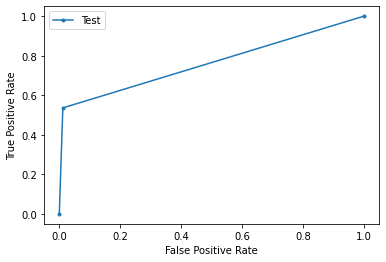

In [ ]:
y_true = y_test
y_predicted = y_pred 
fpr, tpr, _ = roc_curve(y_true, y_predicted)
pyplot.plot(fpr, tpr, marker='.', label='Test')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

По сравнению с бейзлайном на всех данных precision меток 0 и 1 снизился до 0.95 и 0.81, recall метки 1 снизился до 0.54, f1-score снизился до 0.94. Результаты по сравнению с top 10000 features улучшились.

### Top 50000 features

In [ ]:
top50000_features = top_features[:50000]

In [ ]:
X_train_eli5 = X_train[:,top50000_features]
X_test_eli5 = X_test[:,top50000_features]

In [ ]:
eli5_model = SGDClassifier().fit(X_train_eli5, y_train)

In [ ]:
y_pred = eli5_model.predict(X_test_eli5)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     66765
           1       0.81      0.55      0.65      7007

    accuracy                           0.94     73772
   macro avg       0.88      0.77      0.81     73772
weighted avg       0.94      0.94      0.94     73772



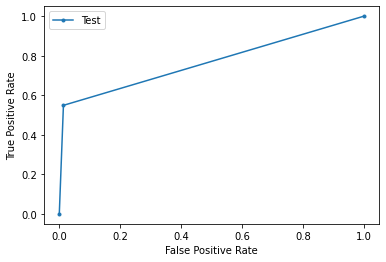

In [ ]:
y_true = y_test
y_predicted = y_pred 
fpr, tpr, _ = roc_curve(y_true, y_predicted)
pyplot.plot(fpr, tpr, marker='.', label='Test')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

По сравнению с бейзлайном на всех данных precision меток 0 и 1 снизился до 0.95 0.82, recall метки 1 снизился до 0.54. Результаты по сравнению с top 30000 features улучшились.

## 3. Ансамбль из моделей в sklearn (ансамблевые модели типа randomforest не считаются). Нужно минимум 5 разных моделей - 2 балла

На даунсэмпле

In [18]:
X = data_downsampled['comment_text']
y = data_downsampled['toxic']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Без параметров

In [20]:
from sklearn.utils.testing import all_estimators

estimators = all_estimators()

for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
GridSearchCV
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NoSampleWeightWrapper
NuSVC
OneVsRestClassifier
Pipeline
QuadraticDiscriminantAnalysis
RFE
RFECV
RadiusNeighborsClassifier
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
StackingClassifier
VotingClassifier
_BinaryGaussianProcessClassifierLaplace
_ConstantPredictor


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [21]:
clf1 = MultinomialNB()
clf2 = SVC()
clf3 = LogisticRegression()
clf4 = DecisionTreeClassifier()
clf5 = XGBClassifier()

eclf = VotingClassifier(estimators=[
        ('MNB', clf1), ('SVC', clf2), ('LogReg', clf3),  ('DecTree', clf4),  ('XGB', clf5)], voting='hard')

In [22]:
voting = Pipeline([
    ('vect', CountVectorizer(analyzer='word', max_features=200)),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('to_dense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
    ('clf', eclf),
    ])

In [23]:
voting = voting.fit(X_train, y_train)

In [24]:
predictions = voting.predict(X_test)

In [25]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.83
Recall:   0.83
F1-measure:   0.83
Accuracy:   0.83


По сравнению с бейзлайном на даунсэмпле метрики получились на порядок меньше. 

## 4. Любая нейронная модель (минимум 5 слоев) с Dropout, Pooling и колбеками - 2 балла

На даунсэмпле

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
vocab = Counter()

for text in data_downsampled['comment_text']:
    vocab.update(preprocess(text))

In [ ]:
len(vocab)

102673

In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)

In [ ]:
len(filtered_vocab)

27207

In [ ]:
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
X = []

for text in data_downsampled['comment_text']:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)

In [ ]:
MEAN_LEN = np.median([len(x) for x in X])

In [ ]:
MAX_LEN, MEAN_LEN

(2321, 28.0)

In [ ]:
MAX_LEN = 35

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [ ]:
X.shape

(42768, 35)

In [ ]:
y = data_downsampled.toxic.values

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [ ]:
filepath = '/gdrive/My Drive/exam/model.weights'

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                monitor='val_f1', 
                                                verbose=1, 
                                                save_weights_only=True, 
                                                save_best_only=True,
                                                mode='max', 
                                                save_freq='epoch' 
                                               )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, 
                                              patience=3, 
                                              verbose=1, 
                                              mode='max',
                                              )

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=2, filters=24, strides=1)(embeddings)
drop1 = tf.keras.layers.Dropout(0.1)(conv1)
conv2 = tf.keras.layers.Conv1D(kernel_size=1, filters=16, strides=1, activation='relu')(drop1)
pool1 = tf.keras.layers.GlobalAveragePooling1D()(conv2)
drop2 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop2)

conv3 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(embeddings)
conv4 = tf.keras.layers.Conv1D(kernel_size=6, filters=16, strides=1, activation='relu')(conv3)
pool2 = tf.keras.layers.GlobalMaxPooling1D()(conv4)
drop3 = tf.keras.layers.Dropout(0.3)(pool2)
convs.append(drop3)

conv5 = tf.keras.layers.Conv1D(kernel_size=8, filters=32, strides=1, kernel_regularizer='l2')(embeddings)
conv6 = tf.keras.layers.Conv1D(kernel_size=10, filters=16, strides=1, activation='relu')(conv5)
pool3 = tf.keras.layers.GlobalAveragePooling1D()(conv6)
drop4 = tf.keras.layers.Dropout(0.4)(pool3)
convs.append(drop4)

conv7 = tf.keras.layers.Conv1D(kernel_size=2, filters=16, strides=2, kernel_regularizer='l2')(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=2, filters=16, strides=2, activation='relu')(conv7)
pool4 = tf.keras.layers.GlobalMaxPooling1D()(conv8)
drop5 = tf.keras.layers.Dropout(0.5)(pool4)
convs.append(drop5)

concat = tf.keras.layers.concatenate(convs)

dense = tf.keras.layers.Dense(64, activation='relu')(concat)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10,
         callbacks=[checkpoint, early_stop])

Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.2324 - f1: 0.4832
Epoch 00001: val_f1 improved from -inf to 0.61628, saving model to /gdrive/My Drive/exam/model.weights
21/21 [==============================] - 16s 754ms/step - loss: 1.2324 - f1: 0.4832 - val_loss: 0.9908 - val_f1: 0.6163
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.8170 - f1: 0.7328
Epoch 00002: val_f1 improved from 0.61628 to 0.82849, saving model to /gdrive/My Drive/exam/model.weights
21/21 [==============================] - 15s 736ms/step - loss: 0.8170 - f1: 0.7328 - val_loss: 0.5873 - val_f1: 0.8285
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.4961 - f1: 0.8464
Epoch 00003: val_f1 improved from 0.82849 to 0.87461, saving model to /gdrive/My Drive/exam/model.weights
21/21 [==============================] - 15s 733ms/step - loss: 0.4961 - f1: 0.8464 - val_loss: 0.4069 - val_f1: 0.8746
Epoch 4/10
21/21 [==============================] - ETA: 0s -

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


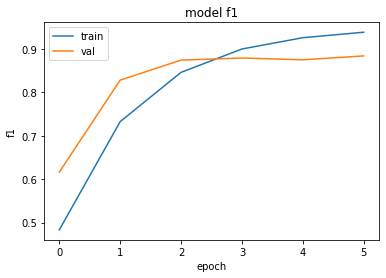

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Судя по графику в модели наблюдается небольшое переобучение, но f1-мера 0.88 на тесте оказалась на несколько процентов лучше, чем в бейзлайне на всех данных 0.83 и почти такой же как в бейзлайне на даунсэмпле 0.89.

## 5. Использование токенизации на символьные нграммы (не параметром analyzer=’char’, а вручную или готовым энструментов вроде youtokentome - 2 балла

С использованием кода по youtokentome Алексея Доркина на даунсэмпле

In [ ]:
cd '/gdrive/My Drive/exam/'

/gdrive/My Drive/exam


In [ ]:
train, test = train_test_split(data_downsampled, test_size=0.3, random_state=0) 

In [ ]:
comments = train.comment_text.to_csv(index=False, header=None) 

In [ ]:
with open('/gdrive/My Drive/exam/comments.txt', 'w') as file: 
  new_comments = re.sub(r'\"{2,}', '', comments) 
  new_comments = re.sub(r'\n+', ' ', new_comments) 
  file.write(new_comments)

In [ ]:
%%time
yttm.BPE.train('/gdrive/My Drive/exam/comments.txt', '/gdrive/My Drive/exam/bpe.model', vocab_size=2000, coverage=0.9999, n_threads=-1, pad_id=0, unk_id=1) 

CPU times: user 1.55 s, sys: 90.9 ms, total: 1.64 s
Wall time: 1.21 s


In [ ]:
bpe_model = yttm.BPE('/gdrive/My Drive/exam/bpe.model', n_threads=-1) # читаем модель из файла

In [ ]:
encoded_comments = bpe_model.encode(data_downsampled.comment_text.tolist(), output_type=yttm.OutputType.ID) # на выходе получаем сразу ID подслов в предложениях, что нам и нужно на входе в сеть

In [ ]:
data_downsampled['encoded_comments'] = encoded_comments # записываем закодированные версии для всех предложений

In [ ]:
train, test = train_test_split(data_downsampled, test_size=0.3, random_state=0) # опять делим на трейн и тест (с тем же сидом, чтобы разделение было такое же)

In [ ]:
[bpe_model.id_to_subword(num) for num in encoded_comments[0]][:10] # модель содержит словарь подслов

['▁h', 'mm', 'mm', '...', '▁app', 'are', 'nt', 'ly', '▁i', "▁didn't"]

In [ ]:
MAX_LEN = max(len(text) for text in train['encoded_comments'])
MAX_LEN

4982

In [ ]:
MEAN_LEN = np.median([len(text) for text in train['encoded_comments']])
MEAN_LEN

54.0

In [ ]:
len(bpe_model.vocab())

2000

In [ ]:
MAX_LEN = 60
X_train = tf.keras.preprocessing.sequence.pad_sequences(train['encoded_comments'], maxlen=MAX_LEN)
X_valid = tf.keras.preprocessing.sequence.pad_sequences(test['encoded_comments'], maxlen=MAX_LEN)

In [ ]:
y_train = train['toxic']
y_valid = test['toxic']

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', 
                                                monitor='val_f1', 
                                                verbose=1, 
                                                save_weights_only=True, 
                                                save_best_only=True,
                                                mode='max', 
                                                save_freq='epoch' 
                                               )

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, 
                                              patience=3, 
                                              verbose=1, 
                                              mode='max',
                                              )

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(bpe_model.vocab()), output_dim=50)(inputs, )
convs = []

conv1 = tf.keras.layers.Conv1D(kernel_size=2, filters=24, strides=1)(embeddings)
drop1 = tf.keras.layers.Dropout(0.1)(conv1)
conv2 = tf.keras.layers.Conv1D(kernel_size=1, filters=16, strides=1, activation='relu')(drop1)
pool1 = tf.keras.layers.GlobalAveragePooling1D()(conv2)
drop2 = tf.keras.layers.Dropout(0.2)(pool1)
convs.append(drop2)

conv3 = tf.keras.layers.Conv1D(kernel_size=4, filters=32, strides=1)(embeddings)
conv4 = tf.keras.layers.Conv1D(kernel_size=6, filters=16, strides=1, activation='relu')(conv3)
pool2 = tf.keras.layers.GlobalMaxPooling1D()(conv4)
drop3 = tf.keras.layers.Dropout(0.3)(pool2)
convs.append(drop3)

conv5 = tf.keras.layers.Conv1D(kernel_size=8, filters=32, strides=1, kernel_regularizer='l2')(embeddings)
conv6 = tf.keras.layers.Conv1D(kernel_size=10, filters=16, strides=1, activation='relu')(conv5)
pool3 = tf.keras.layers.GlobalAveragePooling1D()(conv6)
drop4 = tf.keras.layers.Dropout(0.4)(pool3)
convs.append(drop4)

conv7 = tf.keras.layers.Conv1D(kernel_size=2, filters=16, strides=2, kernel_regularizer='l2')(embeddings)
conv8 = tf.keras.layers.Conv1D(kernel_size=2, filters=16, strides=2, activation='relu')(conv7)
pool4 = tf.keras.layers.GlobalMaxPooling1D()(conv8)
drop5 = tf.keras.layers.Dropout(0.5)(pool4)
convs.append(drop5)

concat = tf.keras.layers.concatenate(convs)

dense = tf.keras.layers.Dense(64, activation='relu')(concat)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=15,
         callbacks=[checkpoint, early_stop])

Epoch 1/15
15/15 [==============================] - ETA: 0s - loss: 1.2205 - f1: 0.5272
Epoch 00001: val_f1 improved from -inf to 0.62807, saving model to model.weights
15/15 [==============================] - 14s 910ms/step - loss: 1.2205 - f1: 0.5272 - val_loss: 1.0964 - val_f1: 0.6281
Epoch 2/15
15/15 [==============================] - ETA: 0s - loss: 0.9972 - f1: 0.6406
Epoch 00002: val_f1 improved from 0.62807 to 0.69330, saving model to model.weights
15/15 [==============================] - 13s 878ms/step - loss: 0.9972 - f1: 0.6406 - val_loss: 0.8687 - val_f1: 0.6933
Epoch 3/15
15/15 [==============================] - ETA: 0s - loss: 0.7483 - f1: 0.7649
Epoch 00003: val_f1 improved from 0.69330 to 0.81240, saving model to model.weights
15/15 [==============================] - 13s 879ms/step - loss: 0.7483 - f1: 0.7649 - val_loss: 0.6201 - val_f1: 0.8124
Epoch 4/15
15/15 [==============================] - ETA: 0s - loss: 0.5717 - f1: 0.8263
Epoch 00004: val_f1 improved from 0.812

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


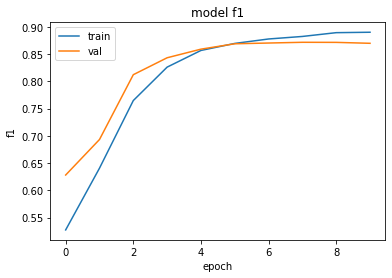

In [ ]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

По сравнению с бейзлайном на даунсэмпле (0.89) метрика f1 в сверточной нейронной модели на символах получилась немного меньше (0.87).

## 6. Поиск аутлаеров в данных с помощью кластеризации (нужно найти хотя бы 20 странных не одинаковых текста)  - 1.5 балла

In [ ]:
sample = data_downsampled.sample(frac=0.01)

In [ ]:
cv = CountVectorizer()
svd = TruncatedSVD(50)
X = cv.fit_transform(sample['comment_text'])
X_svd = svd.fit_transform(X)

y = sample['toxic']

In [ ]:
cluster = DBSCAN(min_samples=5, eps=0.5) 
cluster.fit(X_svd)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [ ]:
labels = cluster.labels_

In [ ]:
sample['cluster'] = cluster.labels_

In [ ]:
set(cluster.labels_)

{-1, 0, 1}

In [ ]:
len(set(cluster.labels_))

3

In [ ]:
sample[sample.cluster==0]


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,encoded_comments,cluster
197793,9866e05088c29349,im a fucking spz,1,0,1,0,0,0,"[813, 520, 1016, 1113, 67]",0
185357,66a2fb0d8f33392f,chocolate bar because jessca sucks,1,0,0,0,0,0,"[774, 1166, 664, 649, 533, 557, 903, 693, 924,...",0
148183,482629b853c64d75,Coward. \n\nStop deleting these messages.,1,0,0,0,1,0,"[598, 588, 756, 24, 1116, 639, 850, 544, 1229,...",0
127732,ab32d6a49fb44e30,Bloody bots get more annoying every day.... He...,1,0,0,0,0,0,"[580, 14, 902, 18, 533, 558, 11, 872, 885, 548...",0
208651,c37a28261ff09be4,Suck a fuckin dick bitch,1,0,1,0,1,0,"[582, 597, 520, 667, 522, 1222, 1198]",0
208758,c3f42a0d7c1762c7,Dude like era sucks,1,0,0,0,1,0,"[609, 830, 5, 732, 4, 527, 7, 1310]",0
221430,f74d3df5c6b4fbdd,WikiI I suck ProjectBannerShell,1,0,1,0,0,0,"[1960, 27, 540, 960, 615, 614, 1011, 50, 1311,...",0
146825,321e5e8929a3f0dc,chicken shit cock sucking pussy bastard!,1,0,1,0,1,0,"[774, 792, 547, 936, 1465, 960, 544, 542, 916,...",0
10052,1a9983326bf9364f,go suck a dick \n\nplease 71.178.201.4,1,0,1,0,1,0,"[786, 960, 520, 1222, 1146, 1689, 56, 904, 75,...",0
148828,52b800e978482ba2,Yeah. go suck dick u corrupt retarded fat pig ...,1,1,1,0,1,1,"[578, 5, 1412, 24, 786, 960, 1222, 622, 535, 5...",0


In [ ]:
sample[sample.cluster==-1]


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,encoded_comments,cluster
125615,9ffb423fd34659d4,Cody Porter dies while foolishly copying Kimim...,1,0,0,0,0,0,"[598, 1582, 615, 536, 735, 550, 831, 1666, 537...",-1
103946,2c268795b3b37b74,"""\nYou dopy little fuck, """"wee curry monster""""...",1,0,1,0,1,0,"[595, 720, 550, 639, 18, 1217, 667, 29, 595, 4...",-1
79325,d44cf9c28c392d29,Shut you dub drunk bastard. Have a great at yo...,1,0,1,0,1,0,"[1576, 594, 546, 550, 953, 550, 12, 1911, 1971...",-1
189526,77754b5bd4d46ab5,Idiots need to be confronted in the language t...,1,0,1,0,1,0,"[540, 15, 1326, 11, 980, 551, 573, 1578, 12, 1...",-1
126015,a1fe5fb23532f41f,"""\nWikipedia has plenty of built-in mechanisms...",0,0,0,0,0,0,"[595, 769, 796, 542, 541, 688, 18, 556, 533, 1...",-1
...,...,...,...,...,...,...,...,...,...,...
26144,452cc619998777ce,This article does not meet wikipedia standard ...,0,0,0,0,0,0,"[989, 660, 922, 599, 652, 617, 1207, 1797, 756...",-1
52623,8cbab258d760c6b5,"""{| class=""""messagebox standard-talk"""" style=""...",0,0,0,0,0,0,"[595, 91, 79, 1230, 996, 53, 43, 43, 19, 924, ...",-1
166601,1c4f835d65f07171,==What the fuck does this mean?== \n\n incompr...,1,0,0,0,0,0,"[768, 45, 1712, 529, 667, 922, 632, 1355, 57, ...",-1
120667,8577f232edddfbc4,Did he? \n\nIs there any evidence that he DIDN...,0,0,0,0,0,0,"[609, 589, 677, 57, 1409, 809, 748, 875, 1893,...",-1


In [ ]:
sample[sample.cluster==1]


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,encoded_comments,cluster
8243,15eb1135c7e08836,"Check the diff, swedefag",1,0,0,0,0,0,"[598, 605, 569, 529, 1289, 22, 29, 526, 23, 53...",1
26355,45c8a5c6592eb25c,through the fourth wall,0,0,0,0,0,0,"[1866, 529, 537, 680, 644, 528, 753]",1
108379,435c0ab4787f122c,I removed the contentious section.,0,0,0,0,0,0,"[540, 1877, 529, 1470, 969, 1237, 24]",1
188860,74b1faee25f10504,the band called lockjaw SUCKS ASSSSSSSSSSSSSSS...,1,0,1,0,1,0,"[529, 533, 669, 1919, 572, 1010, 61, 1703, 100...",1
179377,4ebb9ac7aa2e5169,fuck the world cuz i fucked ur mother,1,1,1,0,1,0,"[667, 529, 1601, 535, 16, 67, 789, 667, 534, 6...",1
174897,3cf2789290384003,STFU SHUT THE FCK UP,1,0,1,0,0,0,"[1540, 44, 36, 1039, 946, 858, 587, 591, 1722]",1
